# Cover Type Prediction of Forests - Kaggle competition


** Use cartographic variables to classify forest categories with machine learning.**

Details about the Kaggle competition at the following URL: https://www.kaggle.com/c/sd701-cover-type-prediction-of-forests/

*Ioan Catana, November 16, 2018 *

## Methodology Report

### Executive summary

This report contains the analysis about the methodology used to predict the forest cover type using the dataset provided in the Kaggle competition which corresponds to cartographic variables collected from US Geological Survey and US Forest Service (USFS).

In this project I started with the PYSPARK.ML package, however I finally used the Python **Scikit-learn** tools for data mining and data analysis. I continued with the Scikit-learn library mainly for two reasons:
- for the same prediction algorithm (ex: *RandomForestClassifier*) with the same parameters, better results are obtained by Scikit-learn compared to PYSPARK.ML package.
- Scikit-learn contains *ExtraTreesClassifier* algorithm which is not available in PYSPARK.ML. *ExtraTreesClassifier* performs better than *RandomForestClassifier* for the current dataset. More generaly, Extra-Trees seems to get higher performance in presence of noisy features. A very good article on Extra-(Randomized)-Trees (ET) is provided by Pierre Geurts, Damien Ernst, Louis Wehenke at this link: ["Extremely randomized trees"](https://orbi.uliege.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf).

In the following rows I have described the data analysis and all the actions I have done in order to find the best predictive model which better predicts the cover type. Each action or feature change was tested individually to see if it makes a positive impact on the predictions or not. When testing different prediction models I have used cross validation to determine the optimal values for the correspondent input parameters. More precisely, I had split the training dataset in two parts, the first 80% used to train the model and the rest of 20% to validate the predictions and calculate the accuracy. 
The final predictions were done on the test dataset and the best accuracy (0.95988) obtained on the Kaggle competition was achieved with the *ExtraTreesClassifier* from *Scikit-learn*.


### Data Process and Analysis



After checking if there were empty values, I have dropped the `Id` column which has not much interest in prediction of the cover type. Then I have run a basic random forest algorithm to have the first results as a baseline before doing any parameters optimization or trying different prediction models.

Before tuning any prediction model I tried to analyze the data inside the input dataset. From the first prediction algorithm I retrieved the list of most important features used by random forest.

Then I plot the **histograms** for each of the most important features to see if there are outliers and also to see if we need to  center or normalize them. I have centered and normalized those and then run again the prediction algorithm to see if there were any improvement. At the end of the test the results were not as good as our baseline so I decided to keep the values as initially in the dataset without the normalization.

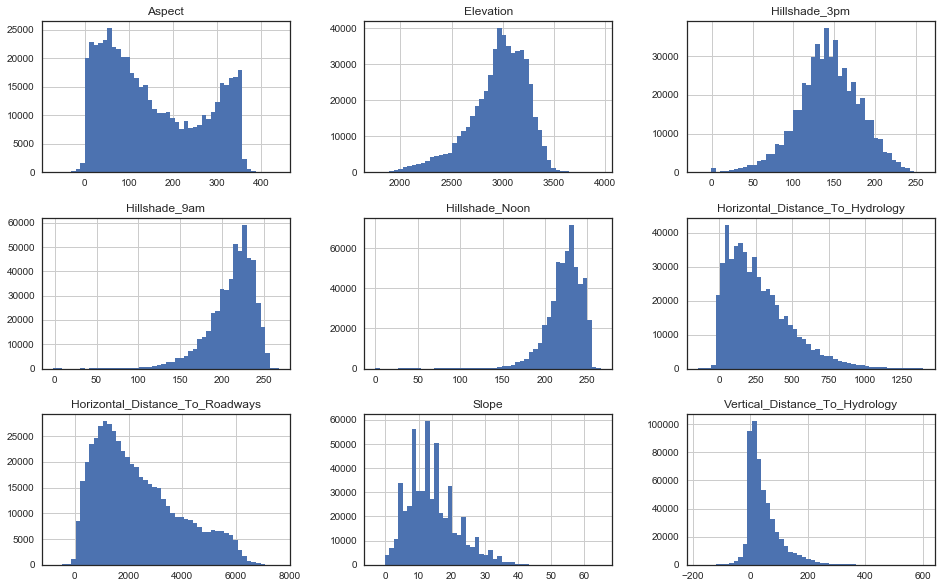

In [20]:
df_train.ix[:,:9].hist(figsize=(16,10), bins=50)
plt.show()

From the histograms I also observed that some of the features are more skewed than the average. In fact, when the absolute value of their skew is greater than 1, we need to apply a log transformation to make them more normal. After applying the log function to those I did a new prediction, however the results were not as good as initially, thus I decided not to continue with the log transformation.


The next step done in analyzing the input data, was looking at the **correlations** between main features in the dataset. 

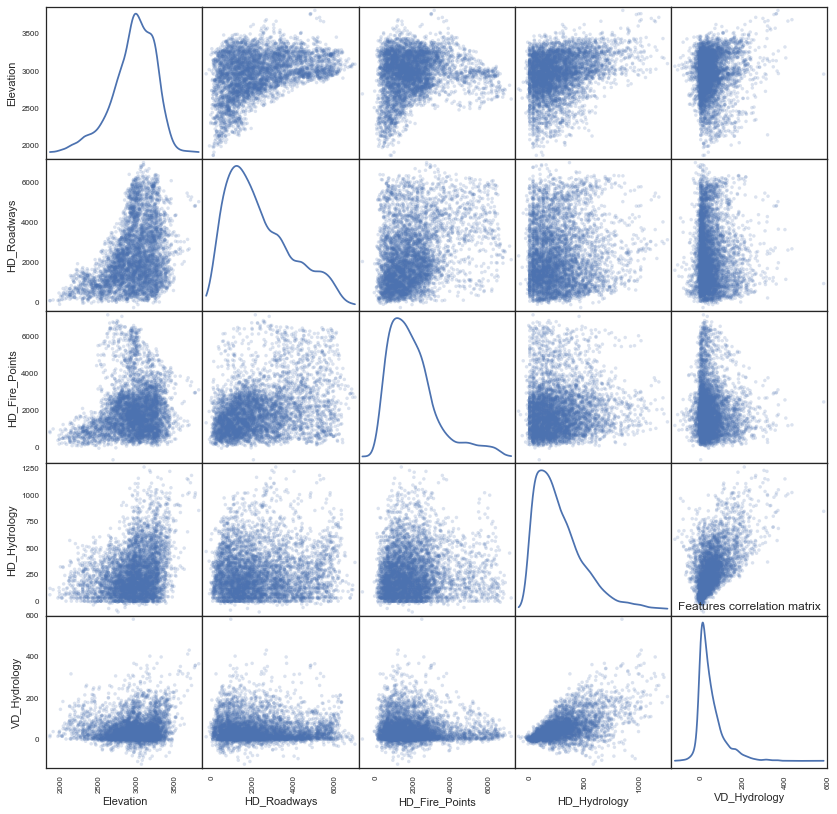

In [30]:
with sns.axes_style('white'): 
    small_df=df_train[['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 
                               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']] 
    small_df.columns=small_df.columns.map(lambda x: x.replace('Horizontal_Distance_To','HD')) 
    small_df.columns=small_df.columns.map(lambda x: x.replace('Vertical_Distance_To','VD')) 
    pd.plotting.scatter_matrix(small_df[:5000], figsize=(14, 14), diagonal="kde", alpha=0.2) 

plt.title('Features correlation matrix')
plt.show()

From the above correlation matrix I noticed that some of the variable are correlated together so I tried to combine those in order to create new composed features which may have a better impact on the decision trees.
An example of features for which we can notice a strong relationship is `Vertical Distance to Hydrology` and `Horizontal Distance to Hydrology`. Using the Pythagoras theorem I have created a new feature combining these two and then included into the original dataset. Then I have run the basic prediction algorithm and because I observed a small improvement in the accuracy score, I have decided to keep this new feature.

This encouraged me to search for new combinations between the original input features. Therefore I have added some new combined features like here below:
- Elevation distance to Hydrology
- Elevation distance to Roadways
- Mean distance to Fire_Points, Hydrology and Roadways

After running again the basic prediction model I have seen a new small improvement in the accuracy, thus I also kept these new features in my new datasets.

Another thing I have tried on the input features is to **reverse back the One Hot encoding** of the different types of soil as well as for the different wilderness areas. Models using ensembles of decision trees (like Random Forest or Extra Trees) can perform better with categorical variables in their initial form compared to the One Hot form. Also reversing back the One Hot encoding has the advantage to reduce the matrix sparsity and therefore to reduce the amount of memory needed to store the datasets.

This transformation also improved the cover type predictions and I continued to use this transformation further.

At this moment I have decided to stop the feature engineering and start with the predictive model optimization.

### Predictive Models



The first approach I used is cross validation in order to automatically find the best values for several input parameters that provides better score for random forest classifier. For doing this I have divided the training dataset in two parts, 80% for doing the learning part and the remaining 20% for doing the validation. The accuracy obtained for the 20% validation part gave me a very good idea of the final Kaggle score. 

I have fixed the number of trees `n_estimators` to 100 value and then I have varied the following parameters: 

`    param_grid = {
        'bootstrap': [True, False],
        'max_depth': [80, 90, 100, 110],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'criterion': ['gini', 'entropy',
        'n_estimators': [100]
    }
`

Best parameters found for Random Forest model from the 80% of the training set were the following:

`{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'criterion': 'entropy', 'n_estimators': 100}`


Next approach to improve predictions score was to try different other algorithms and find for each one the optimal parameters values. 

The following ones were tested with their best accuracy:

Prediction Algorithm | Best Accuracy
--- | ---
ExtraTreesClassifier | 0.957973974882
BaggingClassifier with DecisionTreeClassifier | 0.954474958390
RandomForestClassifier | 0.950569299440
KNeighborsClassifier | 0.935561355727
GradientBoostingClassifier | 0.863661295203
XGBClassifier | 0.770719851717




From the above classification I chose to continue with the ExtraTreesClassifier and the correspondent optimal parameters found were:
`{'oob_score': False, 'min_samples_leaf': 1, 'max_features': 16, 'criterion': 'entropy', 'class_weight': 'balanced', 'n_estimators': 1000}`


After that I have tried to explore other possibilities of improving accuracy.

- Since KNeighbors classifier is much different than Trees algorithms I have tried to create a corresponding new meta feature from its results and then add it to the dataset. However even if I added some random component in order not to select it like  most important feature, the final results obtained with ExtraTrees were below our previous best accuracy.
- I have also tried to separate each class from the others by replacing the other with zero value and run the prediction algorithm independently for each of the seven classes. After that I have concatenated to independent results correspondent to each class and then submitted to Kaggle, but the results were not so good and I have abandoned this idea.
- One more tentative was to blend all the results together from several different classifiers (ExtraTrees, DecisionTree,KNeighbors,GradientBoosting) and use the logistic regression to estimate the best prediction. This method should work only if the algorithms used are all different and all perform very well. In my case the final results obtained were lower compared to the best results from ExtraTrees alone.
- I have also tried to use voting method instead of the logistic regression, however the results were not better than the ExtraTrees alone.



### APPENDIX

#### PYTHON SOURCE CODE

All the Python source code I used for my analysis and to generate predictions with different algorithms is listed here below.

**Imports**

In [ ]:
# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.externals import joblib
import random
import seaborn as sns

**Load Training data**

In [ ]:
# Load data
train_file = 'D:/Dev/CoverTypeForest/train-set.csv'
df_train = pd.read_csv(train_file, sep = ',')

# Display first rows of the dataset
df_train.head()

**Load Test data**

In [ ]:
# Load data
test_file = 'D:/Dev/CoverTypeForest/test-set.csv'
df_test = pd.read_csv(test_file, sep = ',')

# Display first rows of the dataset
df_test.head()

**Start changing features**

In [ ]:
new_train = df_train.copy()
new_cols = ['id', 'soil_type', 'wa', 'elevation', 'aspect', 'slope', 'hd_hy', 'vd_hy', 'hd_rd', 'hs_9',
       'hs_noon', 'hs_3', 'hd_fp', 'cover_type']
new_train.columns = new_cols
new_train.head(1)

In [ ]:
columns = ['id', 'cover_type']
new_train.drop(columns, inplace=True, axis=1)
new_train.head(1)

In [ ]:
#Always call fit on the estimator before invoking this method. 
def importances(model, col_array, title): 
    # Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    print("Top Important Features\n", title)
    for f in range(col_array.shape[1]-1): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
        
    #Mean Feature Importance 
    print("\nMean Feature Importance ", np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices], color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=8, rotation=90)
    plt.xlim([-1, 10])
    plt.show()
    

**Slope distance and Percent to Hydrology**

In [ ]:
#Create two new columns named Slope hydrology and Slope hydrology percent and remove any infinite values that may result 
new_train['slope_hyd'] = np.sqrt(new_train.vd_hy**2 + new_train.hd_hy**2) 
new_train.slope_hyd=new_train.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) 

new_train['slope_hyd_pct'] = new_train.vd_hy / new_train.hd_hy 
new_train.slope_hyd_pct=new_train.slope_hyd_pct.map(lambda x: 0 if np.isinf(x) else x)

new_train.head()

In [ ]:
#Apply changes to test.csv as well
new_test['slope_hyd'] = np.sqrt(new_test.vd_hy**2 + new_test.hd_hy**2) 
new_test.slope_hyd = new_test.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) 

new_test['slope_hyd_pct'] = new_test.vd_hy / new_test.hd_hy 
new_test.slope_hyd_pct = new_test.slope_hyd_pct.map(lambda x: 0 if np.isinf(x) else x)

In [ ]:
#Remove infinity values
new_train[new_train==np.inf] = np.nan
new_train.fillna(new_train.mean(), inplace=True)
new_test[new_test==np.inf] = np.nan
new_test.fillna(new_test.mean(), inplace=True)

**Elevation adjusted by distance to Hydrology and Roadways**

In [ ]:
#Elevation adjusted by Horizontal distance to Hyrdrology 
new_train['Elev_to_HD_Hyd']=new_train.elevation - 0.2 * new_train.hd_hy 
new_test['Elev_to_HD_Hyd']=new_test.elevation - 0.2 * new_test.hd_hy 
#Elevation adjusted by Horizontal distance to Roadways 
new_train['Elev_to_HD_Road']=new_train.elevation - 0.05 * new_train.hd_rd 
new_test['Elev_to_HD_Road']=new_test.elevation - 0.05 * new_test.hd_rd 
#Elevation adjusted by Vertical distance to Roadways 
new_train['Elev_to_VD_Hyd']=new_train.elevation - new_train.vd_hy 
new_test['Elev_to_VD_Hyd']=new_test.elevation - new_test.vd_hy
new_train.head(1)

**Distance to Amenities**

In [ ]:
#Mean distance to Amenities 
new_train['Mean_Amenities']=(new_train.hd_fp + new_train.hd_hy + new_train.hd_rd) / 3 
new_test['Mean_Amenities']=(new_test.hd_fp + new_test.hd_hy + new_test.hd_rd) / 3 
#Mean Distance to Fire and Water 
new_train['Mean_Fire_Hyd']=(new_train.hd_fp + new_train.hd_hy) / 2 
new_test['Mean_Fire_Hyd']=(new_test.hd_fp + new_test.hd_hy) / 2 
new_train.head(1)

In [ ]:
# Write transformed data set to CSV
new_train_file = 'D:/Dev/CoverTypeForest/newfeatures_1-train-set.csv'
new_train.to_csv(new_train_file, sep=',', index=False)
new_test_file = 'D:/Dev/CoverTypeForest/newfeatures_1-test-set.csv'
new_test.to_csv(new_test_file, sep=',', index=False)

In [ ]:
# Load data
new_train_file = 'D:/Dev/CoverTypeForest/newfeatures-train-set.csv'
new_train = pd.read_csv(new_train_file, sep = ',')
new_test_file = 'D:/Dev/CoverTypeForest/newfeatures-test-set.csv'
new_test = pd.read_csv(new_test_file, sep = ',')

**Replace with zeros**

In [ ]:
df_train['Cover_Type'].replace(
    to_replace=[1,2,3,4,5,6],
    value=0,
    inplace=True
)

In [ ]:
sub_test_df = pd.DataFrame(sub_test)
sub_test_df['Cover_Type'].replace(
    to_replace=[1,2,3,4,5,6],
    value=0,
    inplace=True
)

In [ ]:
#Derive counts of each predicted label in the test dataset 
class_weights_test=pd.DataFrame({'Class_Count':sub_test_df['Cover_Type'].groupby(sub_test_df['Cover_Type']).agg(len)}, index=None) 
class_weights_test['Class_Weights'] = sub_test.groupby(sub_test_df['Cover_Type']).agg(len)/len(sub_test_df['Cover_Type'])
print(class_weights_test)

In [ ]:
#Derive counts of each predicted label in the test dataset 
class_weights_train=pd.DataFrame({'Class_Count':df_train['Cover_Type'].groupby(df_train['Cover_Type']).agg(len)}, index=None) 
class_weights_train['Class_Weights'] = df_train['Cover_Type'].groupby(df_train['Cover_Type']).agg(len)/len(df_train['Cover_Type'])
print(class_weights_train)

**Determine Class Weights based on test.csv predictions**

In [ ]:
# Load data
submission_file = 'D:/Dev/CoverTypeForest/feature_eng_submission_class.csv'
sub_test = pd.read_csv(submission_file, sep = ',')
sub_test=sub_test['Cover_Type']

In [ ]:
#Derive counts of each predicted label in the test dataset 
class_weights_test=pd.DataFrame({'Class_Count':sub_test.groupby(sub_test).agg(len)}, index=None) 
class_weights_test['Class_Weights'] = sub_test.groupby(sub_test).agg(len)/len(sub_test)
print(class_weights_test)

We obtain a little improvement with class_weights, the accuracy is the same by using train or test, so we will use train

**Test the ExtraTreesClassifier on new training dataset**

In [ ]:
classes  = df_train['Cover_Type']
# Split the training set into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(new_train, classes, test_size = 0.2, random_state = 1)

# Apply class weights
sample_weights=class_weights_test.ix[y_train] 

In [ ]:
extc_d = ExtraTreesClassifier(n_estimators = 1000, n_jobs = -1, random_state = 1,
                            max_features = 15, criterion = 'entropy', class_weight='balanced')

In [ ]:
# ExtraTreesClassifier
extc_d = ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, random_state = 1,
                            max_features = 15, criterion = 'entropy', class_weight='balanced')

extc_d.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)
y_ext = extc_d.predict(X_test)
print(metrics.classification_report(y_test, y_ext))
print("Accuracy :", metrics.accuracy_score(y_test, y_ext))

Top Important Features
 Cover Type features with ExtraTreesClassifier
1. Elev_to_HD_Hyd (0.125694)
2. Elev_to_VD_Hyd (0.125193)
3. soil_type (0.118205)
4. elevation (0.084819)
5. Elev_to_HD_Road (0.075894)
6. wa (0.064270)
7. hd_rd (0.056002)
8. Mean_Amenities (0.051174)
9. hd_fp (0.048011)
10. Mean_Fire_Hyd (0.045590)
11. aspect (0.027576)
12. hs_noon (0.026090)
13. slope_hyd (0.025075)
14. hd_hy (0.023954)
15. hs_9 (0.023944)
16. vd_hy (0.022045)
17. hs_3 (0.020368)
18. slope (0.018454)

Mean Feature Importance  0.05263157894736842


<IPython.core.display.Javascript object>


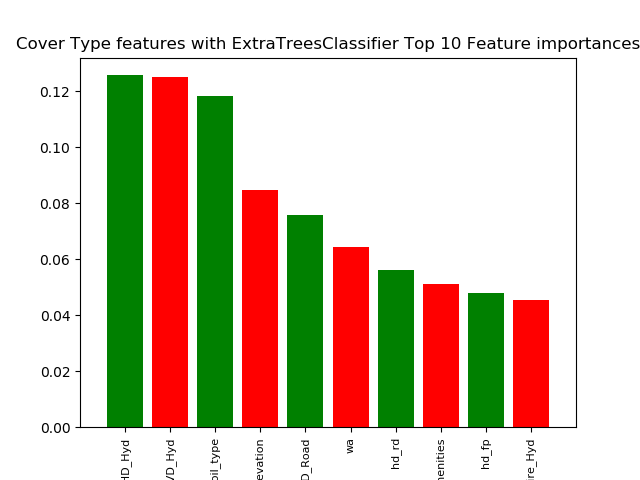

In [24]:
#Call the method we just created to display the feature importances
importances(extc_d, X_train, "Cover Type features with ExtraTreesClassifier")

**Retrain with entire training set and predict test set.**

In [ ]:
# Retrain with entire training set and predict test set.
# Apply class weights
sample_weights=class_weights_test.ix[classes] 
extc_d.fit(new_train, classes, sample_weight=sample_weights.Class_Weights.values)
y_test_ext = extc_d.predict(new_test)

# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/last_submission_1600.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_ext}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)

In [ ]:
# Dump the model
joblib.dump(extc_d, 'extc_d.pkl')

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/feature_eng_submission.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_ext}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)
    

**DecisionTreeClassifier**

In [ ]:
# DecisionTreeClassifier & BaggingClassifier
#dtc = DecisionTreeClassifier(n_estimators = 1000, n_jobs = -1, random_state = 1, splitter = 'random',
#                            max_features = 17, criterion = 'entropy', class_weight='balanced')

dtc = DecisionTreeClassifier(random_state = 1, max_features = 17, splitter = 'random',
            criterion='entropy', class_weight='balanced')

bcdtc = BaggingClassifier(base_estimator=dtc, n_jobs = -1, random_state = 1,
            n_estimators = 800, max_features = 17,
            bootstrap = True,
            oob_score = True)

#bcdtc.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)
#y_bcdtc = bcdtc.predict(X_test)
#print(metrics.classification_report(y_test, y_bcdtc))
#print("Accuracy :", metrics.accuracy_score(y_test, y_bcdtc))

In [ ]:
# Retrain with entire training set and predict test set.
# Apply class weights
sample_weights=class_weights_test.ix[classes] 
bcdtc.fit(new_train, classes, sample_weight=sample_weights.Class_Weights.values)
y_test_bcdtc = bcdtc.predict(new_test)

In [ ]:
# Dump the model
joblib.dump(bcdtc, 'bcdtc.pkl')

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/fe_submission_bcdtc.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_bcdtc}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)
    

**GradientBoostingClassifier**

In [ ]:
#Best classifier is GradientBoostingClassifier
#Best params={'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 6, 
#'max_features': 1.0, 'n_estimators': 100}

# GradientBoostingClassifier(learning_rate=0.1, max_depth=6, max_features=1.0, 
#                                       min_samples_leaf=3, n_estimators=100)
gbc = GradientBoostingClassifier(learning_rate=0.1, random_state = 1,
                                 max_features = 17, loss = 'deviance', max_depth = 40,
                                 n_estimators = 100, criterion = 'friedman_mse')

gbc.fit(X_train, y_train)
y_gbc = gbc.predict(X_test)
print(metrics.classification_report(y_test, y_gbc))
print("Accuracy :", metrics.accuracy_score(y_test, y_gbc))

In [ ]:
# Retrain with entire training set and predict test set.
# Apply class weights
sample_weights=class_weights_test.ix[classes] 
gbc.fit(new_train, classes, sample_weight=sample_weights.Class_Weights.values)
y_test_gbc = gbc.predict(new_test)

In [ ]:
# Dump the model
joblib.dump(gbc, 'gbc.pkl')

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/fe_submission_gbc.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_gbc}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)

**RandomForestClassifier**


In [ ]:
#rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 1,
#                            max_features = 16, criterion = 'entropy', class_weight='balanced')
rf = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 1, 
                            max_features = 17, criterion = 'entropy', class_weight='balanced')

#rf.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)
#y_rf = rf.predict(X_test)
#print(metrics.classification_report(y_test, y_rf))
#print("Accuracy :", metrics.accuracy_score(y_test, y_rf))

In [ ]:
# Retrain with entire training set and predict test set.
# Apply class weights
sample_weights=class_weights_test.ix[classes] 
rf.fit(new_train, classes, sample_weight=sample_weights.Class_Weights.values)
y_test_rf = rf.predict(new_test)

In [ ]:
# Dump the model
joblib.dump(rf, 'rf.pkl')

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/fe_submission_rf.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_rf}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)

**KNeighborsClassifier**

In [12]:
#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#           n_neighbors=7, p=1, weights='distance')
knnc = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', n_jobs = -1,
                                 n_neighbors=7, p=1, weights='distance')

knnc.fit(X_train, y_train)
y_knnc = knnc.predict(X_test)
print(metrics.classification_report(y_test, y_knnc))
print("Accuracy :", metrics.accuracy_score(y_test, y_knnc))

              precision    recall  f1-score   support

           1       0.94      0.93      0.93     38499
           2       0.94      0.95      0.95     51492
           3       0.92      0.92      0.92      6579
           4       0.85      0.80      0.82       469
           5       0.86      0.81      0.83      1693
           6       0.88      0.87      0.88      3242
           7       0.93      0.92      0.93      3770

   micro avg       0.94      0.94      0.94    105744
   macro avg       0.90      0.89      0.90    105744
weighted avg       0.94      0.94      0.94    105744

Accuracy : 0.9355613557270389


In [ ]:
# Retrain with entire training set and predict test set.
knnc.fit(new_train, classes)
y_test_knnc = knnc.predict(new_test)

In [ ]:
# Dump the model
joblib.dump(knnc, 'knnc.pkl')

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/fe_submission_knnc.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_knnc}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)

**Create new feature from above**

In [ ]:
new_train_knn = new_train.copy()
new_train_knn['knn_class'] = y_alltrain_knnc_df['Cover_Type'] 

In [ ]:
new_test_knn = new_test.copy()
new_test_knn['knn_class'] = y_test_knnc_df['Cover_Type'] 


In [ ]:
random.seed(1)
new_train_mean = pd.DataFrame()
new_test_mean = pd.DataFrame()
new_train_mean['mean'] = new_train.mean(axis=1)
new_train_mean['std'] = new_train.std(axis=1)
new_train_mean['rand1'] = np.random.uniform(1,52,(528720))
new_train_mean['rand2'] = np.random.uniform(5,10,(528720))
new_test_mean['mean'] = new_test.mean(axis=1)
new_test_mean['std'] = new_test.std(axis=1)
new_test_mean['rand1'] = np.random.uniform(1,22,(226595))
new_test_mean['rand2'] = np.random.uniform(5,10,(226595))

In [ ]:
# Add the new knn feature
new_train_knn = new_train.copy()
new_train_knn['knn_class']=y_alltrain_knnc_df['Cover_Type']*new_train_mean['mean']*new_train_mean['std']* \
    new_train_mean['rand1']/10000000
new_test_knn = new_test.copy()
new_test_knn['knn_class']=y_test_knnc_df['Cover_Type']*new_test_mean['mean']*new_test_mean['std']* \
        new_test_mean['rand1']/10000000

In [ ]:
new_train_mean['rand'] = np.random.uniform(1,528720,(528720))
new_train_mean.head()

**Test the ExtraTreesClassifier on new knn training dataset**

In [ ]:
classes  = df_train['Cover_Type']
# Split the training set into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(new_train_knn, classes, test_size = 0.2, random_state = 1)

# Apply class weights
sample_weights=class_weights_test.ix[y_train] 

In [175]:
# ExtraTreesClassifier
extc_k = ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, random_state = 1,
                            max_features = 16, criterion = 'entropy', class_weight='balanced')

extc_k.fit(X_train, y_train, sample_weight=sample_weights.Class_Weights.values)
y_ext_k = extc_k.predict(X_test)
print(metrics.classification_report(y_test, y_ext_k))
print("Accuracy :", metrics.accuracy_score(y_test, y_ext_k))

              precision    recall  f1-score   support

           1       0.96      0.97      0.96     38499
           2       0.97      0.97      0.97     51492
           3       0.95      0.97      0.96      6579
           4       0.93      0.88      0.90       469
           5       0.96      0.82      0.88      1693
           6       0.95      0.91      0.93      3242
           7       0.99      0.96      0.97      3770

   micro avg       0.96      0.96      0.96    105744
   macro avg       0.96      0.92      0.94    105744
weighted avg       0.96      0.96      0.96    105744

Accuracy : 0.9627402027538206


Top Important Features
 Cover Type features with ExtraTreesClassifier and KNN feature
1. knn_class (0.154747)
2. Elev_to_HD_Hyd (0.118590)
3. soil_type (0.106259)
4. Elev_to_VD_Hyd (0.102000)
5. elevation (0.088825)
6. Elev_to_HD_Road (0.067742)
7. wa (0.053431)
8. Mean_Amenities (0.048913)
9. hd_rd (0.042452)
10. hd_fp (0.035417)
11. Mean_Fire_Hyd (0.033715)
12. aspect (0.019403)
13. hs_noon (0.019166)
14. slope_hyd (0.017921)
15. hs_9 (0.017398)
16. hd_hy (0.016816)
17. vd_hy (0.015898)
18. hs_3 (0.014899)
19. slope (0.013432)

Mean Feature Importance  0.05


<IPython.core.display.Javascript object>


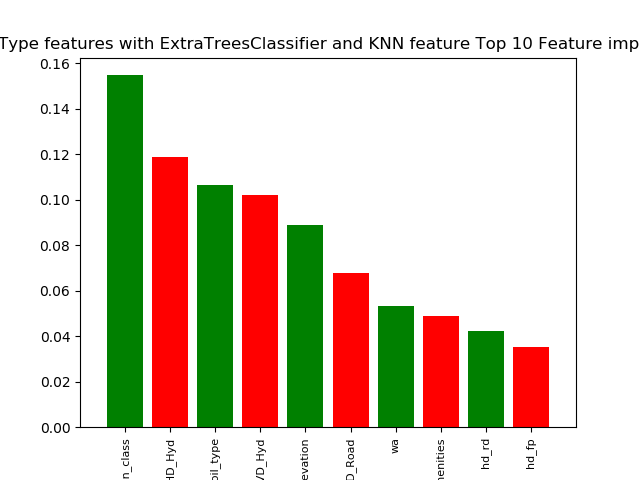

In [176]:
#Call the method we just created to display the feature importances
importances(extc_k, X_train, "Cover Type features with ExtraTreesClassifier and KNN feature")

In [ ]:
# Retrain with entire training set and predict test set.
# Apply class weights
sample_weights=class_weights_test.ix[classes] 
extc_k.fit(new_train_knn, classes, sample_weight=sample_weights.Class_Weights.values)
y_test_ext_k = extc_k.predict(new_test_knn)


In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/feature_eng_submission_ext_knn.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_test_ext_k}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)

**Considerer classes independently**

In [ ]:
new_test_1 = new_test.copy()
new_test_knn['knn_class'] = y_test_knnc_df['Cover_Type'] 


In [ ]:
df_train_1 = df_train.loc[df_train['Cover_Type'] == 1]
df_train_2 = df_train.loc[df_train['Cover_Type'] == 2]

In [ ]:
# Write transformed data set to CSV
fillzeros_train_file = 'D:/Dev/CoverTypeForest/fillzeros-train-set.csv'
new_train.to_csv(fillzeros_train_file, sep=',', index=False)

In [ ]:
new_test = df_test.copy()
new_cols_test = ['id', 'soil_type', 'wa', 'elevation', 'aspect', 'slope', 'hd_hy', 'vd_hy', 'hd_rd', 'hs_9',
       'hs_noon', 'hs_3', 'hd_fp']
new_test.columns = new_cols_test
new_test.head(1)

drop_columns = ['id']
new_test.drop(drop_columns, inplace=True, axis=1)
new_test.head(1)

In [ ]:
#Make a copy and Reorder test.csv columns 
temp=new_test.copy() 
cols=temp.columns.tolist() 
cols=cols[:10]+cols[11:]+[cols[10]] 
temp=temp[cols]


In [ ]:
#Extract missing rows from test.csv then predict and fill in the blanks. 
X_testcsv_missing = temp[temp.hs_3==0].values[:,:-1] 
temp.hs_3.loc[temp.hs_3==0] = gbrt.predict(X_testcsv_missing) 
new_test.hs_3=temp.hs_3

In [ ]:
# Write transformed data set to CSV
fillzeros_test_file = 'D:/Dev/CoverTypeForest/fillzeros-test-set.csv'
new_test.to_csv(fillzeros_test_file, sep=',', index=False)

In [ ]:
# Dump the model
joblib.dump(extc_d, 'extc_d.pkl')

In [ ]:
# Load the model
extc_d = joblib.load('extc_d.pkl')

**Save predictions**

In [ ]:
# Extra trees predictions
y_train_ext = extc_d.predict(X_train)
y_ext = extc_d.predict(X_test)
y_test_ext = extc_d.predict(new_test)
y_train_ext_df = pd.DataFrame(y_train_ext)
y_ext_df = pd.DataFrame(y_ext)
y_test_ext_df = pd.DataFrame(y_test_ext)

In [ ]:
# DecisionTreeClassifier & BaggingClassifier
y_train_bcdtc = bcdtc.predict(X_train)
y_bcdtc = bcdtc.predict(X_test)
y_test_bcdtc = bcdtc.predict(new_test)
y_train_bcdtc_df = pd.DataFrame(y_train_bcdtc)
y_bcdtc_df = pd.DataFrame(y_bcdtc)
y_test_bcdtc_df = pd.DataFrame(y_test_bcdtc)

In [ ]:
# GradientBoostingClassifier predictions
y_train_gbc = gbc.predict(X_train)
y_gbc = gbc.predict(X_test)
y_test_gbc = gbc.predict(new_test)
y_train_gbc_df = pd.DataFrame(y_train_gbc)
y_gbc_df = pd.DataFrame(y_gbc)
y_test_gbc_df = pd.DataFrame(y_test_gbc)

In [ ]:
# RandomForestClassifier predictions
y_train_rf = rf.predict(X_train)
y_rf = rf.predict(X_test)
y_test_rf = rf.predict(new_test)
y_train_rf_df = pd.DataFrame(y_train_rf)
y_rf_df = pd.DataFrame(y_rf)
y_test_rf_df = pd.DataFrame(y_test_rf)

In [ ]:
# KNeighborsClassifier predictions
y_train_knnc = knnc.predict(X_train)
y_knnc = knnc.predict(X_test)
y_test_knnc = knnc.predict(new_test)
y_train_knnc_df = pd.DataFrame(y_train_knnc)
y_knnc_df = pd.DataFrame(y_knnc)
y_test_knnc_df = pd.DataFrame(y_test_knnc)

In [ ]:
y_alltrain_knnc = knnc.predict(new_train)
y_alltrain_knnc_df = pd.DataFrame(y_alltrain_knnc)
y_alltrain_knnc_df.columns = ['Cover_Type']
y_test_knnc_df.columns = ['Cover_Type']

In [ ]:
# Write transformed data set to CSV
my_file = 'D:/Dev/CoverTypeForest/y_test_knnc.csv'
y_test_knnc_df.to_csv(my_file, sep=',', index=False)

**Compute matrix of all results on training and test sets**

In [ ]:
#Classifiers = [ 'ext', 'bcdtc', 'rf', 'knnc']
Classifiers = [ 'ext', 'knnc']
X_blend_train = pd.DataFrame()
X_blend_test  = pd.DataFrame()
X_blend_testcsv  = pd.DataFrame()

for clf in Classifiers:
    df = pd.read_csv("D:/Dev/CoverTypeForest/y_train_%s.csv" % clf)
    X_blend_train = pd.concat([X_blend_train, df], axis=1)
    df = pd.read_csv("D:/Dev/CoverTypeForest/y_%s.csv" % clf)
    X_blend_test = pd.concat([X_blend_test, df], axis=1)
    df = pd.read_csv("D:/Dev/CoverTypeForest/y_test_%s.csv" % clf)
    X_blend_testcsv = pd.concat([X_blend_testcsv, df], axis=1)


In [56]:
X_blend_train.head()

,0,0,0
0,2,2,2
1,6,6,6
2,2,2,2
3,2,2,2
4,3,3,3


**Blend results with Logistic Regression**

In [67]:
lo=LogisticRegression().fit(X_blend_train, y_train)

In [68]:
y_pred=lo.predict(X_blend_test)

print("Ensemble Learning - Blending Random Forests & Extra Trees Results") 
print("-----------------------------------------------------------------") 
print("Blended Training Score: ", lo.score(X_blend_train, y_train)) 
print("Blended Test Score: ", lo.score(X_blend_test, y_test)) 
print("Classification Report - Blended Test") 
print(metrics.classification_report(y_test, y_pred))


Ensemble Learning - Blending Random Forests & Extra Trees Results
-----------------------------------------------------------------
Blended Training Score:  0.8877454039945529
Blended Test Score:  0.8866791496444243
Classification Report - Blended Test
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     38499
           2       0.81      1.00      0.90     51492
           3       0.00      0.00      0.00      6579
           4       0.00      0.00      0.00       469
           5       0.00      0.00      0.00      1693
           6       0.00      0.00      0.00      3242
           7       1.00      1.00      1.00      3770

   micro avg       0.89      0.89      0.89    105744
   macro avg       0.40      0.43      0.41    105744
weighted avg       0.79      0.89      0.84    105744



In [42]:
#Run Predictions on test.csv 
y_final_pred_ext=lo.predict(X_blend_testcsv)

**Combine Results with Majority Vote**

In [23]:
cols = ["ext", "bcdtc", "rf", "knnc"]
X_blend_train.columns = cols
X_blend_test.columns = cols
X_blend_testcsv.columns = cols
X_blend_train.head()

,ext,bcdtc,rf,knnc
0,2,2,2,2
1,6,6,6,6
2,2,2,2,2
3,2,2,2,2
4,3,3,3,3


In [24]:
voters = ['ext', 'bcdtc', 'rf', 'knnc']

def majority(r):
    vote = [ 0 for i in range(0,7) ]
    for i in range(len(r)):
        vote[ r.ix[i]-1 ] += 1
    return np.argmax(vote)+1

X_blend_train['majority'] = X_blend_train[voters].apply(lambda x: majority(x), axis=1)
print("training data: %2.3f%%" % (100.0*metrics.accuracy_score(y_train, X_blend_train['majority'])))

X_blend_test['majority'] = X_blend_test[voters].apply(lambda x: majority(x), axis=1)
print("testing data: %2.3f%%" % (100.0*metrics.accuracy_score(y_test, X_blend_test['majority'])))


training data: 100.000%
testing data: 100.000%


In [25]:
X_blend_test.head()

,ext,bcdtc,rf,knnc,majority
0,2,2,2,2,2
1,1,1,1,1,1
2,2,2,2,2,2
3,2,2,2,2,2
4,2,2,2,2,2


In [ ]:
#Run Predictions on test.csv 
X_blend_testcsv['majority'] = X_blend_testcsv[voters].apply(lambda x: majority(x), axis=1)
y_final_pred_ext=X_blend_testcsv['majority'].values

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/fe_submission_vote_all.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_final_pred_ext}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)

**Compose the final output**

In [ ]:
Classifiers = [ '1', '2', '3', '4', '5', '6', '7']
#Classifiers = ['1', '2', '3', '4', '5']
X_blend_testcsv  = pd.DataFrame()

for clf in Classifiers:
    df = pd.read_csv("D:/Dev/CoverTypeForest/%s_submission_600.csv" % clf)['Cover_Type']
    X_blend_testcsv = pd.concat([X_blend_testcsv, df], axis=1)
    

In [152]:
X_blend_testcsv.head()

,Cover_Type,Cover_Type,Cover_Type,Cover_Type,Cover_Type,Cover_Type,Cover_Type
0,0,2,0,0,0,0,0
1,0,2,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,2,0,0,0,0,0
4,1,0,0,0,0,0,0


In [153]:
cols = ["1", "2", "3", "4", "5", "6", "7"]
#cols = ["1", "2", "3", "4", "5"]
X_blend_testcsv.columns = cols
X_blend_testcsv.head()

,1,2,3,4,5,6,7
0,0,2,0,0,0,0,0
1,0,2,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,2,0,0,0,0,0
4,1,0,0,0,0,0,0


In [154]:
X_blend_testcsv['2'].replace(
    to_replace=[2],
    value=1,
    inplace=True
)
X_blend_testcsv['3'].replace(
    to_replace=[3],
    value=1,
    inplace=True
)
X_blend_testcsv['4'].replace(
    to_replace=[4],
    value=1,
    inplace=True
)
X_blend_testcsv['5'].replace(
    to_replace=[5],
    value=1,
    inplace=True
)
X_blend_testcsv['6'].replace(
    to_replace=[6],
    value=1,
    inplace=True
)
X_blend_testcsv['7'].replace(
    to_replace=[7],
    value=1,
    inplace=True
)
X_blend_testcsv.head()

,1,2,3,4,5,6,7
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0


In [155]:
# Change from One-Hot to Catecorigal format
X_blend_testcsv['majority'] = (X_blend_testcsv.iloc[:, 0:] == 1).idxmax(1)
X_blend_testcsv.head(10)

,1,2,3,4,5,6,7,majority
0,0,1,0,0,0,0,0,2
1,0,1,0,0,0,0,0,2
2,1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,2
4,1,0,0,0,0,0,0,1
5,0,1,0,0,0,0,0,2
6,1,0,0,0,0,0,0,1
7,0,0,1,0,0,0,0,3
8,0,1,0,0,0,0,0,2
9,0,1,0,0,0,0,0,2


In [ ]:
y_final_pred_ext=X_blend_testcsv['majority'].values

In [ ]:
# Write final results to CSV for Kaggle submission
submission_file = 'D:/Dev/CoverTypeForest/fe_submission_vote_all_1.csv'
pd.DataFrame({'Id':df_test.Id.values,'Cover_Type':y_final_pred_ext}) \
                .sort_index(ascending=False,axis=1).to_csv(submission_file, index=False)